In [2]:
# Import Python modules
import os, sys
import yaml
import numpy as np
import pandas as  pd
import xarray as xr
from datetime import timedelta, date
import textwrap

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from ar_funcs import get_ar_days, duration_stats
from constants import ucsd_colors

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [3]:
# Set up paths
server = "skyriver"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/work/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [37]:
# label strings
ivt_units = 'kg m$^{-1}$ s$^{-1}$'

# Select lat/lon grid
bnds = [360-180., 360-110., 19, 80] # extent of CIMSS Plots
ext1 = [-180., -110., 19, 80] # extent of CIMSS Plots

lonmin, lonmax, latmin, latmax = bnds

# set start and end dates
start_date = '2015-08-14 12:00'
end_date = '2015-08-19 23:00'

In [72]:
%%time
## load AR shape data
filename =  'downloads/AR_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ar_filename = path_to_data + filename
ds = xr.open_dataset(ar_filename)
da = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
da = da.assign_coords({"lon": (((da.lon + 180) % 360) - 180)}) # fix lons
da

CPU times: user 53.2 ms, sys: 3.17 ms, total: 56.4 ms
Wall time: 54.3 ms


<xarray.Dataset>
Dimensions:      (lon: 47, lat: 41, lev: 1, time: 22, ens: 1)
Coordinates:
  * lon          (lon) float64 -180.0 -178.5 -177.0 ... -114.0 -112.5 -111.0
  * lat          (lat) float64 19.5 21.0 22.5 24.0 25.5 ... 75.0 76.5 78.0 79.5
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 2015-08-14T12:00:00 ... 2015-08-19T18:...
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.03.22
    creation_date:         22-Mar-2022 11:12:14
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

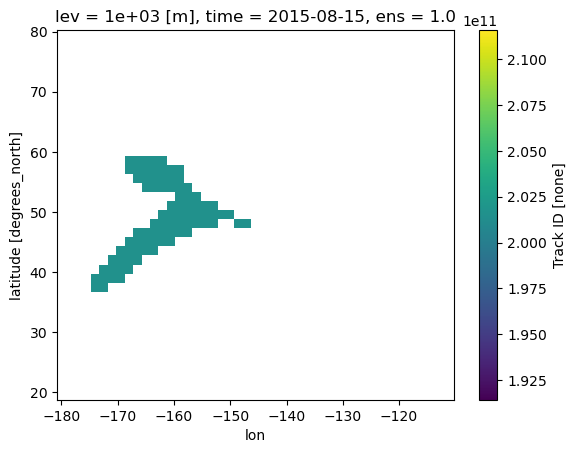

In [73]:
## mask AR data where trackID matches
trackID = 201508141210.0
da = da.where(da.kidmap == trackID)
da.kidmap.isel(time=2).plot()


In [74]:
## open ERA5 data

datelst = ['0814', '0815', '0816', '0817', '0818', '0819']
filenames = []
for i, monthday in enumerate(datelst):
    filenames.append('/data/downloaded/Reanalysis/ERA5/IVT/2015/ERA5_IVT_2015{0}.nc'.format(monthday))
    
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))

era = xr.open_mfdataset(filenames, preprocess=preprocess, combine='by_coords')

## resample to 6-hourly
era = era.resample(time="6H").mean()

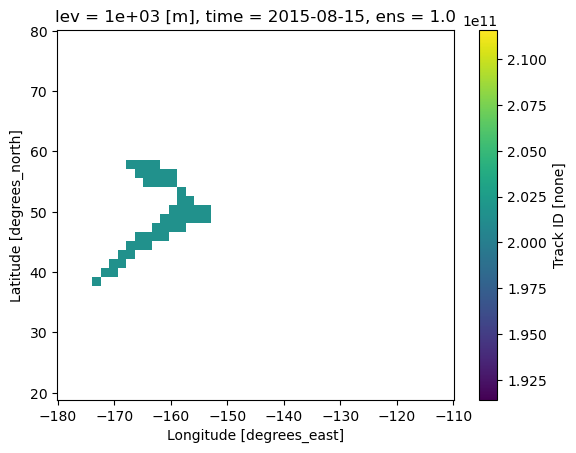

In [75]:
## regrid/interpolate data to all have same grid size
regrid_lats = era.lat
regrid_lons = era.lon

AR = da.kidmap.interp(lon=regrid_lons, lat=regrid_lats)
AR.isel(time=2).plot()

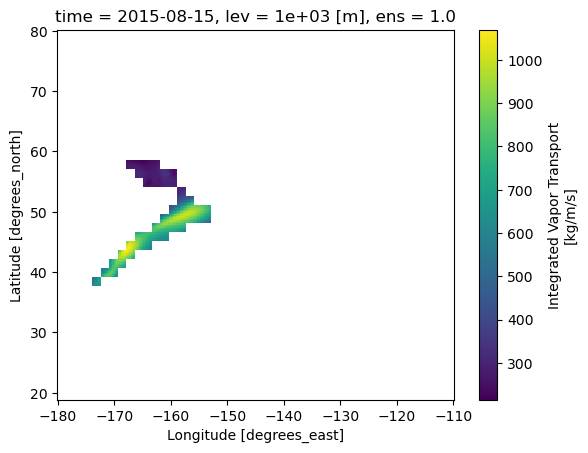

In [79]:
## mask ERA5 data with AR shape
era_masked = era.where(AR == trackID)
era_masked.IVT.isel(time=2).plot()

/home/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


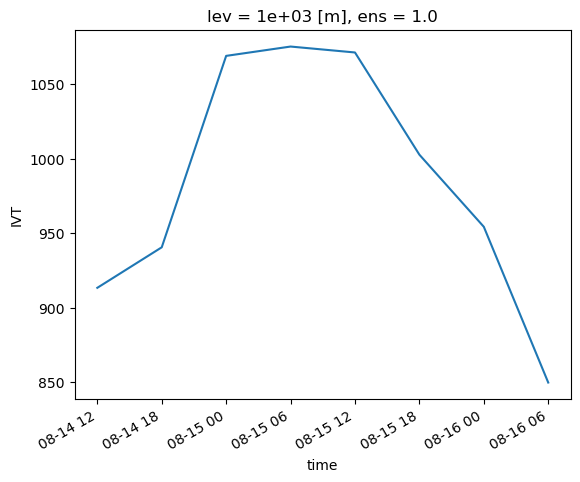

In [83]:
## get average IVT within AR for each time step
avg_IVT = era_masked.mean(['lat', 'lon'])
## get maximum IVT within AR for each time step 
max_IVT = era_masked.max(['lat', 'lon'])
## plot time series of avg AR IVT and max AR IVT
max_IVT.IVT.plot()